# Figures of AU-emotion mappings project
Code to run the analyses that result in the data visualized here is stored in the `src/analysis` directory of this repository.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.facecolor'] = "white"

## Figure 3: main results plot

In [40]:
# SOME PREPROCESSING STUF FOR THE MAIN FIGURE
map2leg = {
    'Darwin': 'Darwin\n(1886)',
    'Matsumoto2008': 'Matsumoto et al.\n(2008)',
    'Keltner2019': 'Keltner et al.\n(2019)',
    'Cordaro2018ref': 'Cordaro et al.\n(2018; ref.)',
    'Cordaro2018IPC': 'Cordaro et al.\n(2018; ICP)',
    'Ekman': 'Friesen &\nEkman (1978)',
    'JackSchyns': 'Jack et al.\n(2014)'
}
files = [
    '../data/Darwin.tsv',
    '../data/Matsumoto2008.tsv',
    '../data/Keltner2019.tsv',
    '../data/Cordaro2018ref.tsv',
    '../data/Cordaro2018IPC.tsv',
    '../data/Ekman.tsv'
]
m_dfs = [pd.read_csv(f, sep='\t', index_col=0) for f in files]
map_names = list(map2leg.values())
emo_names = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
au_names = np.loadtxt('../data/au_names_new.txt', dtype=str)

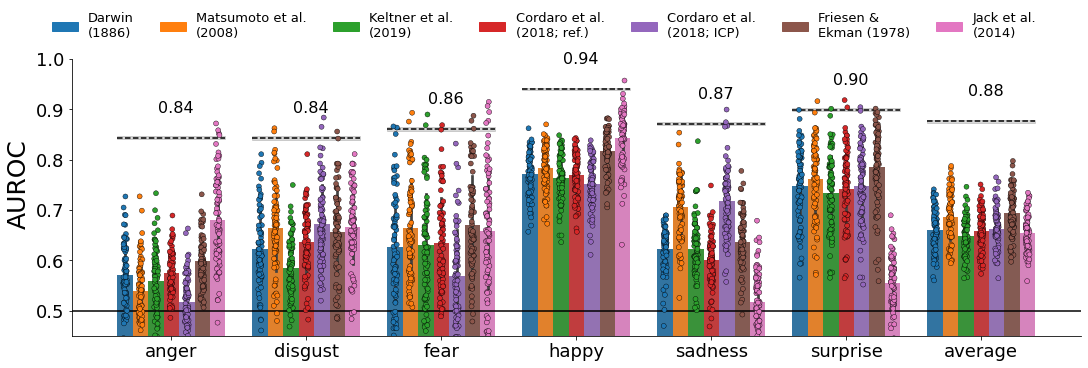

In [41]:
ymin = 0.45
ymax = 1
chance_level = .5

df = pd.read_csv('../results/scores.tsv', sep='\t', index_col=0)
df_js = pd.read_csv('../results/scores_js.tsv', sep='\t', index_col=0)
df_js = df_js.query("model_ethnicity == 'all' & face_gender == 'all'").drop('model_ethnicity', axis=1)
df = pd.concat((df, df_js), axis=0)

# Only results on the train set (sub & split) are shown!
df = df.replace(map2leg)
df = df.query("face_gender == 'all'")

# Add average across mappings to df for plotting (rightmost panel)
df_av = df.groupby(['mapping', 'sub', 'sub_ethnicity']).mean().reset_index()
df = pd.concat([df, df_av.assign(emotion='average')], axis=0)

fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
ax = sns.barplot(x='emotion', y='score', data=df, hue='mapping',
                 ax=ax, ci='sd', hue_order=map_names)

ax = sns.stripplot(x='emotion', y='score', hue='mapping',
                   edgecolor='black', linewidth=0.4, data=df,
                   dodge=True, jitter=True, hue_order=map_names)

ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=25, )
ax.yaxis.set_label_coords(-0.04, 0.55)

# Plot the noise ceiling on top! Also only estimated on train set and
# estimated without regard to ethnicity
nc = pd.read_csv('../results/noise_ceiling.tsv', sep='\t', index_col=0)
nc = nc.query("sub_split == 'train' & trial_split == 'train' & ethn == 'all'")

n_tk = df['mapping'].unique().size
for i in range(6):  # for each emotion separately
    this_nc = np.array([nc['noise_ceiling'].iloc[i]] * n_tk)
    this_sd = np.array([nc['sd'].iloc[i]] * n_tk)
    plt.plot(np.linspace(i-0.4, i+0.4, num=n_tk), this_nc, c='k', ls='--')
    plt.fill_between(
        np.linspace(i-0.4, i+0.4, num=n_tk),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
    )
    plt.text(i - 0.1, this_nc[0] + 0.05, f'{this_nc[0]:.2f}', fontsize=16)

# Plot noise ceiling separately for average across emotions
i += 1
this_nc = np.array([nc['noise_ceiling'].mean()] * n_tk)
this_sd = np.array([nc['sd'].mean()] * n_tk)
plt.plot(np.linspace(i-0.4, i+0.4, num=n_tk), this_nc, c='k', ls='--')
plt.fill_between(
    np.linspace(i-0.4, i+0.4, num=n_tk),
    this_nc - this_sd, this_nc + this_sd,
    color='gray', alpha=0.3
)
plt.text(i - 0.1, this_nc[0] + 0.05, f'{this_nc[0]:.2f}', fontsize=16)

# Some aesthetics
ax.set_facecolor('white')
ax.set_ylim(ymin, ymax)
ax.axhline(chance_level, c='k', ls='-')
ax.legend_.remove()
colors = {mapp: sns.color_palette()[i] for i, mapp in enumerate(map_names)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = plt.legend(handles, labels, ncol=7, loc=(-0.025, 1.05), frameon=False, fontsize=13)

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
sns.despine()
plt.savefig('figure_3.png', bbox_inches='tight', dpi=400, facecolor='white')

For the supplementary materials: how stable are these results in differet splits of the data?

In [ ]:
ymin = 0.4
ymax = 1
chance_level = .5

df = pd.read_csv('../results/scores.tsv', sep='\t', index_col=0)
# Only results on the train set (sub & split) are shown!
df = df.query("trial_split != 'all'")
df['data_split'] = df['sub_split'] + '_' + df['trial_split']
df = df.query("mapping in @map2leg.keys()")
df = df.replace(map2leg)
split2leg = {'train_train': 'Sub: train, Trial: train',
             'train_test': 'Sub: train, Trial: test',
             'test_train': 'Sub: test, Trial: train',
             'test_test': 'Sub: test, Trial: test'}
df = df.replace(split2leg)

# Add average across mappings to df for plotting (rightmost panel)
df_av = df.groupby(['mapping', 'sub', 'trial_split', 'sub_split', 'sub_ethnicity', 'data_split']).mean().reset_index()
df = pd.concat([df, df_av.assign(emotion='average')], axis=0)
df = df.groupby(['sub', 'emotion', 'data_split', 'sub_ethnicity']).mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
ax = sns.barplot(x='emotion', y='score', data=df, hue='data_split',
                 ax=ax, ci='sd', hue_order=split2leg.values())

ax = sns.stripplot(x='emotion', y='score', hue='data_split',
                   edgecolor='black', linewidth=0.4, data=df,
                   dodge=True, jitter=True, hue_order=split2leg.values())

ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=25, )
ax.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax.set_facecolor('white')
ax.set_ylim(ymin, ymax)
ax.axhline(chance_level, c='k', ls='-')
ax.legend_.remove()

colors = {name: sns.color_palette()[i] for i, name in enumerate(split2leg.values())}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = plt.legend(handles, labels, ncol=4, loc=(0, 1.05), frameon=False, fontsize=14)

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
sns.despine()
plt.savefig('figure_SX1.png', bbox_inches='tight', dpi=400, facecolor='white')

Split by ethnicity (averaged across mappings):

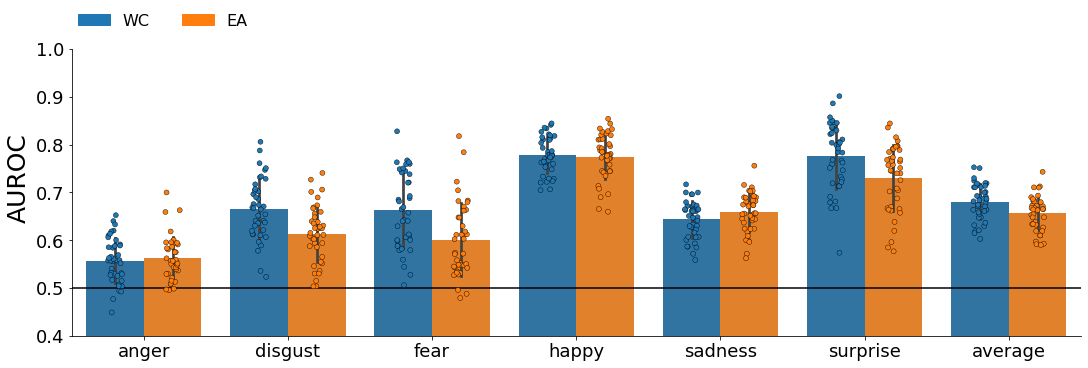

In [43]:
ymin = 0.4
ymax = 1
chance_level = .5

df = pd.read_csv('../results/scores.tsv', sep='\t', index_col=0)
# Only results on the train set (sub & split) are shown!
df = df.query("trial_split == 'train' and sub_split == 'train' & face_gender == 'all'")
df = df.query("mapping in @map2leg.keys()")
df = df.replace(map2leg)

# Add average across mappings to df for plotting (rightmost panel)
df_av = df.groupby(['mapping', 'sub', 'sub_ethnicity']).mean().reset_index()
df = pd.concat([df, df_av.assign(emotion='average')], axis=0)
df = df.groupby(['sub', 'emotion', 'sub_ethnicity']).mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
hue_order = ['WC', 'EA']
ax = sns.barplot(x='emotion', y='score', data=df, hue='sub_ethnicity',
                 ax=ax, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

ax = sns.stripplot(x='emotion', y='score', hue='sub_ethnicity',
                   edgecolor='black', linewidth=0.4, data=df,
                   dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=25, )
ax.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax.set_facecolor('white')
ax.set_ylim(ymin, ymax)
ax.axhline(chance_level, c='k', ls='-')
#ax.legend_.remove()

colors = {name: sns.color_palette()[i] for i, name in enumerate(hue_order)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = plt.legend(handles, labels, ncol=4, loc=(0, 1.05), frameon=False, fontsize=16)

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
sns.despine()
#plt.savefig('figure_SX2.png', bbox_inches='tight', dpi=400, facecolor='white')

Split by ethnicity, shown per mapping:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


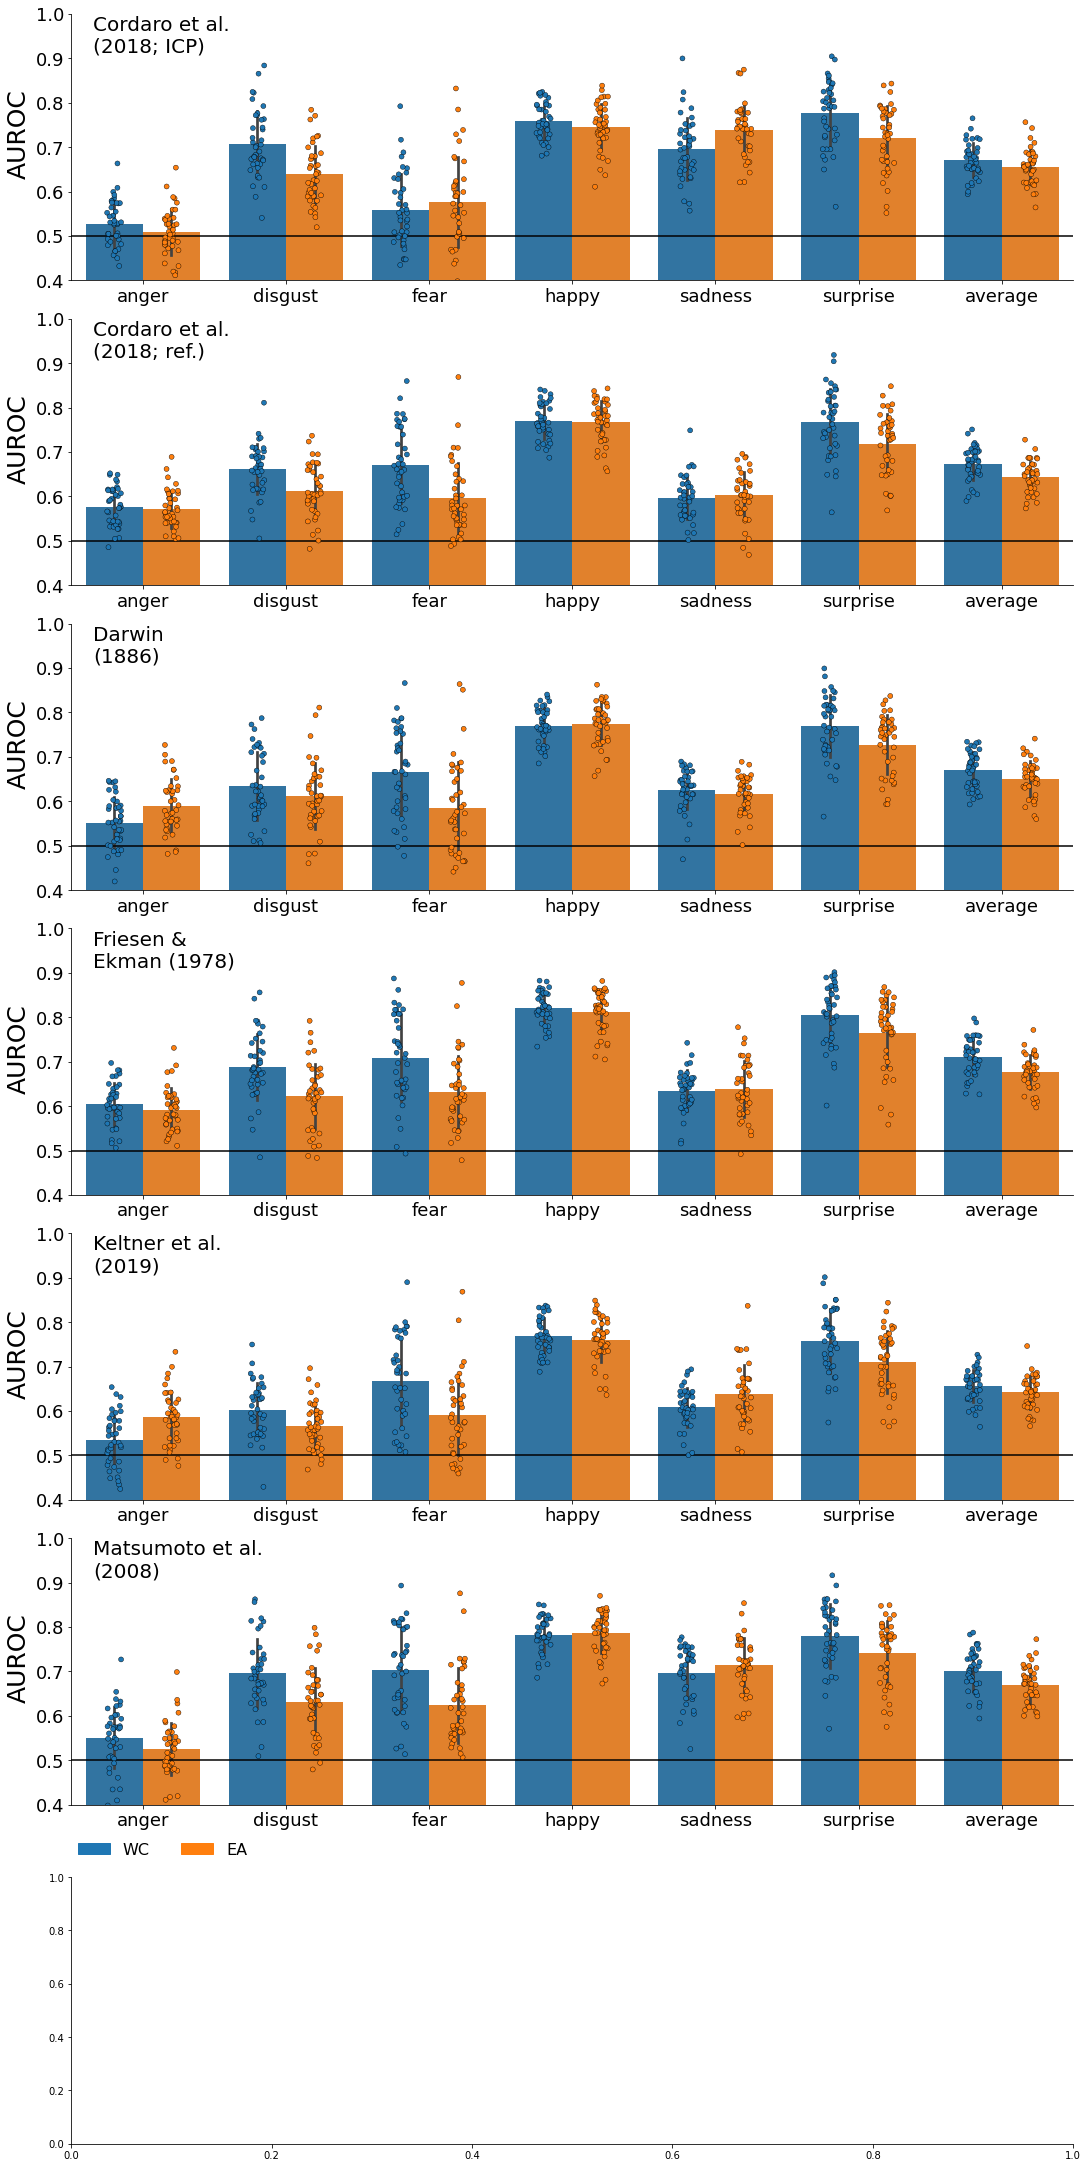

In [44]:
ymin = 0.4
ymax = 1
chance_level = .5

df = pd.read_csv('../results/scores.tsv', sep='\t', index_col=0)
# Only results on the train set (sub & split) are shown!
df = df.query("trial_split == 'train' and sub_split == 'train' & face_gender == 'all'")
df = df.drop(['sub_split', 'trial_split'], axis=1)
df = df.query("mapping in @map2leg.keys()")
df = df.replace(map2leg)

# Add average across mappings to df for plotting (rightmost panel)
df_av = df.groupby(['mapping', 'sub', 'sub_ethnicity']).mean().reset_index()
df = pd.concat([df, df_av.assign(emotion='average')], axis=0)

fig, axes = plt.subplots(figsize=(15, 30), constrained_layout=True, nrows=7)
hue_order = ['WC', 'EA']
for i, mapp in enumerate(df['mapping'].unique()):
    ax = axes[i]
    this_df = df.query("mapping == @mapp")
    ax = sns.barplot(x='emotion', y='score', data=this_df, hue='sub_ethnicity',
                    ax=ax, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

    ax = sns.stripplot(x='emotion', y='score', hue='sub_ethnicity',
                    edgecolor='black', linewidth=0.4, data=this_df, ax=ax,
                    dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

    ax.set_xlabel('')
    ax.set_ylabel('AUROC', fontsize=25, )
    ax.yaxis.set_label_coords(-0.04, 0.55)

    # Some aesthetics
    ax.set_facecolor('white')
    ax.set_ylim(ymin, ymax)
    ax.axhline(chance_level, c='k', ls='-')
    ax.legend_.remove()
    
    colors = {name: sns.color_palette()[i] for i, name in enumerate(hue_order)}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    legend = plt.legend(handles, labels, ncol=4, loc=(0, 1.05), frameon=False, fontsize=16)

    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.text(-0.35, .95, mapp, fontsize=20, va='center')
sns.despine()
plt.savefig('figure_SX3.png', bbox_inches='tight', dpi=400, facecolor='white')

In [ ]:
ymin = 0.4
ymax = 1
chance_level = .5

df = pd.read_csv('../results/scores.tsv', sep='\t', index_col=0)
# Only results on the train set (sub & split) are shown!
df = df.query("trial_split == 'train' and sub_split == 'train'")
df = df.query("face_gender != 'all'")
df = df.query("mapping in @map2leg.keys()")
df = df.replace(map2leg)

# Add average across mappings to df for plotting (rightmost panel)
df_av = df.groupby(['mapping', 'sub', 'sub_ethnicity', 'face_gender']).mean().reset_index()
df = pd.concat([df, df_av.assign(emotion='average')], axis=0)
df = df.groupby(['sub', 'emotion', 'sub_ethnicity', 'face_gender']).mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
hue_order = ['F', 'M']
ax = sns.barplot(x='emotion', y='score', data=df, hue='face_gender',
                 ax=ax, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

ax = sns.stripplot(x='emotion', y='score', hue='face_gender',
                   edgecolor='black', linewidth=0.4, data=df,
                   dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=25, )
ax.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax.set_facecolor('white')
ax.set_ylim(ymin, ymax)
ax.axhline(chance_level, c='k', ls='-')
#ax.legend_.remove()

colors = {name: sns.color_palette()[i] for i, name in enumerate(hue_order)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = plt.legend(handles, labels, ncol=4, loc=(0, 1.05), frameon=False, fontsize=16)

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
sns.despine()
plt.savefig('figure_SX4.png', bbox_inches='tight', dpi=400, facecolor='white')

In [ ]:
ymin = 0.4
ymax = 1
chance_level = .5

df = pd.read_csv('../results/scores.tsv', sep='\t', index_col=0)
# Only results on the train set (sub & split) are shown!
df = df.query("trial_split == 'train' and sub_split == 'train'")
df = df.query("face_gender != 'all'")
df = df.query("mapping in @map2leg.keys()")
df = df.replace(map2leg)

# Add average across mappings to df for plotting (rightmost panel)
df_av = df.groupby(['mapping', 'sub', 'sub_ethnicity', 'face_gender']).mean().reset_index()
df = pd.concat([df, df_av.assign(emotion='average')], axis=0)
df = df.groupby(['sub', 'emotion', 'sub_ethnicity', 'face_gender']).mean().reset_index()

fig, axes = plt.subplots(figsize=(15, 10), nrows=2, constrained_layout=True)
hue_order = ['F', 'M']
for i, ethn in enumerate(df['sub_ethnicity'].unique()):
    ax = axes[i]
    this_df = df.query("sub_ethnicity == @ethn")
    ax = sns.barplot(x='emotion', y='score', data=this_df, hue='face_gender',
                    ax=ax, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

    ax = sns.stripplot(x='emotion', y='score', hue='face_gender',
                    edgecolor='black', linewidth=0.4, data=this_df, ax=ax,
                    dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

    ax.set_xlabel('')
    ax.set_ylabel('AUROC', fontsize=25, )
    ax.yaxis.set_label_coords(-0.04, 0.55)

    # Some aesthetics
    ax.set_facecolor('white')
    ax.set_ylim(ymin, ymax)
    ax.axhline(chance_level, c='k', ls='-')
    ax.legend_.remove()

    colors = {name: sns.color_palette()[i] for i, name in enumerate(hue_order)}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    legend = plt.legend(handles, labels, ncol=4, loc=(0, 1.05), frameon=False, fontsize=16)

    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.text(-0.35, .95, f'Ethnicity: {ethn}', fontsize=20, va='center')

sns.despine()
plt.savefig('figure_SX5.png', bbox_inches='tight', dpi=400, facecolor='white')

## Explanation figure

In [ ]:
from glob import glob
mappings = pd.concat([pd.read_csv(f, sep='\t', index_col=0).assign(mapp=f.split('/')[-1].split(".")[0])
                      for f in glob('../data/*.tsv')])

mappings = mappings.reset_index().groupby(['mapp', 'index']).max().reset_index().set_index('index')

df_abl = pd.read_csv('../results/scores_ablation.tsv', sep='\t', index_col=0)
df_abl = df_abl.replace(map2leg).drop(['sub', 'beta', 'kernel'], axis=1)
heatmap_abl = pd.DataFrame(np.zeros((6, 33)), columns=au_names, index=emo_names)
for emo in emo_names:
    this_df = df_abl.query("score != 0 & ablated_from == @emo & emotion == @emo")
    this_df = this_df.groupby('ablated_au').mean().reset_index()
    for _, row in this_df.iterrows():
        heatmap_abl.loc[emo, row['ablated_au']] = row['score']

heatmap_abl[heatmap_abl == 0] = np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16, 3), constrained_layout=True)
ax = sns.heatmap(heatmap_abl, square=True, ax=ax, cmap='vlag_r', center=0, cbar_kws={'aspect': 50, 'shrink': 1, 'pad': 0.001})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45);
ax.set_yticklabels(emo_names, fontsize=14)
ax.figure.axes[-1].set_ylabel(r'$\Delta$ AUROC', size=16, labelpad=15)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.figure.axes[-1].set_frame_on(True)
#ax.text(33.5, 0.5, 'Improve when ablated')
fig.savefig('figure_4.png', dpi=400)

## Optimal model

In [ ]:
ymin = -0.1
ymax = 0.4
chance_level = 0

df_o = pd.read_csv('../results/scores_optimal.tsv', sep='\t', index_col=0)
df_o = df_o.replace(map2leg)

df_av = df_o.groupby(['mapping', 'sub']).mean().reset_index()
df_o = pd.concat([df_o, df_av.assign(emotion='average')], axis=0)

av_orig = df.groupby(['emotion', 'mapping']).mean()['score']
nc = pd.read_csv('../results/noise_ceiling.tsv', sep='\t', index_col=0)
nc_js = pd.read_csv('../results/noise_ceiling_test.tsv', sep='\t', index_col=0)

# CM stuff
cm_df = pd.read_csv('../results/cm_optimal.tsv', sep='\t', index_col=0)#.reset_index()
cm_df = cm_df.replace(map2leg)
emo_reorder = ['anger', 'disgust', 'fear', 'surprise', 'happy', 'sadness']
emo_short = ['an', 'di', 'fe', 'su', 'ha', 'sa']

In [ ]:
fig = plt.figure(figsize=(15, 10), constrained_layout=True)
gs = fig.add_gridspec(3, 8, height_ratios=[3, 2, 2], width_ratios=[1, 1, 1, 1, 1, 1, 1, 0.2])

ax1 = fig.add_subplot(gs[0, :])
ax1 = sns.barplot(x='emotion', y='score', data=df_o, hue='mapping',
                 ax=ax1, ci='sd')

ax1 = sns.stripplot(x='emotion', y='score', hue='mapping', ax=ax1,
                    edgecolor='black', linewidth=0.4, data=df_o,
                    dodge=True, jitter=True)

# hack to add whitespace between row 1 and 2
ax1.set_xlabel('bla', labelpad=25)
ax1.xaxis.label.set_color('white')
            
ax1.set_ylabel(r'$\Delta$ AUROC', fontsize=20, labelpad=10)
mapps = df['mapping'].unique().size
for i in range(6): 
    orig = av_orig.reset_index().query(f"emotion == '{emo_names[i]}'").set_index('mapping').loc[df['mapping'].unique(), :]
    orig = orig['score'].to_numpy()
    this_nc = np.array([nc['noise_ceiling'].iloc[i]] * 6)
    this_nc = np.append(this_nc, nc_js['noise_ceiling'][i])
    this_sd = np.array([nc['sd'].iloc[i]] * 6)
    this_sd = np.append(this_sd, nc_js['sd'][i])
    this_nc = this_nc - orig
    ax1.plot(np.linspace(i - 0.35, i + 0.35, num=7), this_nc, ls='--', c='k')
    ax1.fill_between(
        np.linspace(i-0.35, i+0.35, num=7),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
    )

i += 1
this_nc = nc['noise_ceiling'].mean()
tmp = df.groupby('mapping').mean()['score'].loc[list(map2leg.values())].to_numpy()[:6]
this_nc = this_nc - tmp
this_nc = np.append(this_nc, nc_js['noise_ceiling'].mean())
this_nc[-1] = this_nc[-1] - tmp[-1]

ax1.plot(np.linspace(i - 0.35, i + 0.35, num=7), this_nc, ls='--', c='k')
this_sd = np.array([nc['sd'].mean()] * 6)
this_sd = np.append(this_sd, nc_js['sd'].mean())

ax1.fill_between(
    np.linspace(i-0.35, i+0.35, num=7),
    this_nc - this_sd, this_nc + this_sd,
    color='gray', alpha=0.3
)

ax1.set_facecolor('white')
ax1.set_ylim(ymin, ymax)
ax1.axhline(chance_level, c='k', ls='-')
ax1.legend_.remove()
colors = {mapp: sns.color_palette()[i] for i, mapp in enumerate(map_names)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax1.legend(handles, labels, ncol=7, loc=(-0.025, 1.05), frameon=False, fontsize=14)

ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=20)
ax1.set_xlim(-0.5, 6.75)
sns.despine()

# CM PLOTS
axes = [[fig.add_subplot(gs[ii, i]) for i in range(7)] for ii in range(1, 3)]
cbar_ax = fig.add_subplot(gs[1:, 7])
I = np.eye(6)
for i, mapp in enumerate(cm_df['mapping'].unique()):
    bg = np.zeros(2)
    for ii, tpe in enumerate(['orig', 'opt']):
        cm = cm_df.query("mapping == @mapp & type == @tpe").drop(['mapping', 'type'], axis=1)
        cm = cm.loc[emo_reorder, emo_reorder].to_numpy()
        bg[ii] = (cm[np.triu_indices_from(cm, k=1)].sum() + cm[np.tril_indices_from(cm, k=-1)].sum()) / 30

        cm /= cm.sum(axis=1)
        
        xtl = emo_short if ii == 1 else False
        ytl = emo_short if i == 0 else False
        cbar = True if i == 6 and ii == 0 else False
        axes[ii][i] = sns.heatmap(
            cm, ax=axes[ii][i], vmin=0, vmax=0.8, square=True, cbar=cbar,
            xticklabels=xtl, yticklabels=ytl, cbar_ax=cbar_ax
        )
        if cbar:
            cbar_ax.set_title('Prop.\ntrials', size=15, pad=10)
            cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size=12)
            cbar_ax.set_box_aspect(19)
            #for axis in ['top','bottom','left','right']:
            #    cbar_ax.spines[axis].set_linewidth(0)
        
        if ii == 0:
            axes[ii][i].set_title(mapp, fontsize=15, pad=10)
        
        if ii == 1:
            axes[ii][i].set_xticklabels(axes[ii][i].get_xticklabels(), rotation=90, fontsize=15)

        if i == 0:
            axes[ii][i].set_yticklabels(axes[ii][i].get_yticklabels(), rotation=0, fontsize=15)

        axes[ii][i].tick_params(axis='x', which='both', bottom=False)
        axes[ii][i].tick_params(axis='y', which='both', left=False)
        #bg[ii] = 1 - (np.sum((cm - I) ** 2) / np.sum((1 - I) ** 2))
    
    delta_bg = (bg[1] - bg[0]) / bg[0] * 100
    axes[1][i].text(3, -1., f"{delta_bg:.1f}%", ha='center', va='center', fontsize=18)

axes[1][0].set_ylabel('True emotion', fontsize=20, ha='center', va='center')
axes[1][0].yaxis.set_label_coords(-0.5, 1.25)
axes[1][3].set_xlabel('Predicted emotion', fontsize=20, labelpad=15)
#axes[1][0].text(-0.5, -1.3, 'Conf.:', fontsize=20, ha='center', va='center')
axes[0][0].text(-1.75, 3, 'Original', fontsize=20, ha='center', va='center', rotation=90)
axes[1][0].text(-1.75, 3, 'Optimal', fontsize=20, ha='center', va='center', rotation=90)

plt.savefig('figure_5.png', dpi=400)

Difference noise ceiling and optimal model:

In [ ]:
opt = (df.groupby(['emotion', 'sub']).mean()['score'] + df_o.groupby(['emotion', 'sub']).mean()['score']).reset_index()

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
sns.barplot(x='emotion', y='score', data=opt,
            ax=ax, ci=None)
ax.set_ylim(0.45, 1.)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
sns.despine()
ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=20)
ax.axhline(0.5, ls='--', c='k')
for i in range(6):
    this_nc = np.array([nc['noise_ceiling'].iloc[i]] * 7)
    this_sd = np.array([nc['sd'].iloc[i]] * 7)
    plt.plot(np.linspace(i-0.4, i+0.4, num=7), this_nc, c='k', ls='--')
    plt.fill_between(
        np.linspace(i-0.4, i+0.4, num=7),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
    )

In [ ]:
(1 - nc['noise_ceiling']) / 0.5

In [ ]:
diff = nc['noise_ceiling'].to_numpy() - opt.groupby('emotion').mean()['score']
diff / 0.5

In [ ]:
((av_orig + df_o.groupby(['emotion', 'mapping']).mean()['score']).reset_index().groupby('emotion').mean()['score']  - 0.5)/0.5

In [ ]:
from scipy.linalg import toeplitz
phi = 0.99
X = phi ** toeplitz(range(6))
I = np.eye(6)
1 - (np.sum((X - I) ** 2) / np.sum((1 - I) ** 2))

# Supplementary materials/results/figures

## Probabilistic predictions vs. discrete predictions

In [ ]:
pp_df = pd.read_csv('../results/prob_vs_discrete_scores.tsv', sep='\t', index_col=0)
pp_df = pp_df.replace(map2leg)

g = sns.catplot(x='mapping', y='score', data=pp_df, hue='method',
                kind="bar", aspect=3, height=5, ci='sd')
ax = g.axes[0, 0]
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Score', fontsize=20)
ax.set_ylim(0.4, 1)
ax.axhline(0.5, ls='--', c='k')
leg = g._legend
leg.set_title('')
leg.get_texts()[0].set_text('discrete')
leg.get_texts()[0].set_fontsize(20)
leg.get_texts()[1].set_text('probabilistic')
leg.get_texts()[1].set_fontsize(20)
leg.set_bbox_to_anchor([0, 0, 0.2, 1.75])
plt.gcf().savefig('figure_S1.png', dpi=200, bbox_inches='tight')

## Hyperparameter figure (Figure S2 & S3)

In [ ]:
nc = pd.read_csv('../results/noise_ceiling.tsv', sep='\t', index_col=0)
nc_js = pd.read_csv('../results/noise_ceiling_test.tsv', sep='\t', index_col=0)

hp_df = pd.read_csv('../results/scores_hyperparameters.tsv', sep='\t', index_col=0)
KERNEL = 'cosine'
g = sns.catplot(x='emotion', y='score', data=hp_df.query("kernel == @KERNEL"), hue='beta', row='mapping',
                kind="bar", aspect=4, height=3, ci='sd')

ymin = 0.45
ymax = 1
chance_level = .5

g._legend.set_title(r'$\beta$')
plt.setp(g._legend.get_title(), fontsize=16)
plt.setp(g._legend.get_texts(), fontsize=16)
for i, ax in enumerate(g.axes.flatten()):
    ax.text(-.6, 1, map_names[i], fontsize=20, verticalalignment='top')
    ax.set_title('')
    
    if map_names[i] == 'Jack & Schyns':
        nc2use = nc_js
    else:
        nc2use = nc
    
    for ii, emo in enumerate(nc['emotion'].unique()):
        this_nc = nc2use.loc[nc2use['emotion'] == emo, 'noise_ceiling']
        this_sd = nc2use.loc[nc2use['emotion'] == emo, 'sd']
        ax.plot(np.linspace(ii-0.4, ii+0.4, num=5), [this_nc]*5, c='k', ls='-.')
        ax.fill_between(
            np.linspace(ii-0.4, ii+0.4, num=5),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )
        ax.set_ylim(ymin, ymax)
        ax.axhline(0.5, ls='--', c='k')
        ax.set_ylabel("AUROC", fontsize=20)

g.set_xlabels('')
g.set_xticklabels(hp_df['emotion'].unique(), fontsize=20)

g._legend.set_bbox_to_anchor([1.05, 0.925])
plt.subplots_adjust(hspace=0.2)
fig = plt.gcf()
fig.tight_layout()
fig.savefig('figure_S2.png', dpi=400, bbox_inches='tight')

In [ ]:
hp_df = pd.read_csv('../results/scores_hyperparameters.tsv', sep='\t', index_col=0)
BETA = 1

g = sns.catplot(x='emotion', y='score', data=hp_df.query("beta == @BETA"), hue='kernel', row='mapping',
                kind="bar", aspect=4, height=3, ci='sd')

g._legend.set_title('Kernel')
plt.setp(g._legend.get_title(), fontsize=16)
plt.setp(g._legend.get_texts(), fontsize=16)

for i, ax in enumerate(g.axes.flatten()):
    ax.text(-.6, 1, map_names[i], fontsize=20, verticalalignment='top')
    ax.set_title('')

    if map_names[i] == 'Jack & Schyns':
        nc2use = nc_js
    else:
        nc2use = nc

    for ii, emo in enumerate(nc['emotion'].unique()):
        this_nc = nc2use.loc[nc2use['emotion'] == emo, 'noise_ceiling']
        this_sd = nc2use.loc[nc2use['emotion'] == emo, 'sd']
        ax.plot(np.linspace(ii-0.4, ii+0.4, num=5), [this_nc]*5, c='k', ls='-.')
        ax.fill_between(
            np.linspace(ii-0.4, ii+0.4, num=5),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )
        ax.set_ylim(ymin, ymax)
        ax.axhline(0.5, ls='--', c='k')
        ax.set_ylabel("AUROC", fontsize=20)

g.set_xlabels('')
g.set_xticklabels(hp_df['emotion'].unique(), fontsize=20)

g._legend.set_bbox_to_anchor([1.075, 0.925])

plt.subplots_adjust(hspace=0.2)
fig = plt.gcf()
fig.tight_layout();
fig.savefig('figure_S3.png', dpi=400, bbox_inches='tight')

## Bias simulations (Supplementary Figure S4)

In [ ]:
df_naus = pd.read_csv('../results/scores_bias_simulation_n_aus.tsv', sep='\t', index_col=0)
df_naus = df_naus.groupby(['mapping', 'n_aus', 'emotion']).mean().reset_index()

df_nconf = pd.read_csv('../results/scores_bias_simulation_n_configs.tsv', sep='\t', index_col=0)
df_nconf = df_nconf.groupby(['mapping', 'n_configs', 'emotion']).mean().reset_index()

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
sns.barplot(x='n_aus', y='score', data=df_naus, ci='sd', ax=axes[0])
sns.barplot(x='n_configs', y='score', data=df_nconf, ci='sd', ax=axes[1])
sns.despine()
axes[0].set_ylim(0.2, 0.8)
for ax in axes:
    ax.axhline(0.5, ls='--', c='k')

axes[0].set_ylabel('AUROC', fontsize=20)
axes[1].set_ylabel('')
axes[0].set_xlabel('Number of AUs per config', fontsize=20)
axes[1].set_xlabel('Number of configs per class', fontsize=20)

axes[0].text(-0.9, 0.85, 'A', fontsize=35)
axes[1].text(-0.9, 0.85, 'B', fontsize=35)

fig.tight_layout()
fig.savefig('figure_S4.png', dpi=400)

In [ ]:
from scipy.stats import ttest_1samp
for emo in df_naus.emotion.unique():
    for n_au in df_naus.n_aus.unique():
        tmp_df = df_naus.query("emotion == @emo & n_aus == @n_au")
        print(ttest_1samp(tmp_df.score, 0.5))

## Ablation analysis (Supplementary Figure 5)

In [ ]:
df_abl = pd.read_csv('../results/scores_ablation.tsv', sep='\t', index_col=0)
df_abl = df_abl.replace(map2leg).drop(['sub', 'beta', 'kernel'], axis=1)

In [ ]:
fig, axes = plt.subplots(nrows=6, figsize=(20, 12), sharey=True, sharex=False,
                         constrained_layout=True)
for i, emo in enumerate(emo_names):
    this_df = df_abl.query("ablated_from == @emo & emotion == @emo")
    axes[i] = sns.barplot(x='ablated_au', y='score', data=this_df, hue='mapping',
                          ci=95, errwidth=1, ax=axes[i])
    if i != 0:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(ncol=7, loc=(0.2, 1.05), frameon=False)

    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    axes[i].text(31, 0.04, emo.capitalize(), fontsize=20, ha='center', va='center')
    axes[i].axhline(0, ls='-', c='k', lw=0.25)

axes[i].set_ylim(-0.07, 0.05)
fig.text(-0.02, 0.5, r'$\Delta$ AUROC', va='center', ha='center',
         rotation='vertical', fontsize=30)
fig.text(0.5, -0.04, 'Ablated AU', va='center', ha='center', fontsize=30)

sns.despine()
fig.savefig('figure_S5.png', dpi=400, facecolor='white')

## Intensity-stratified analysis (supplementary figure 6)

In [ ]:
nc = pd.read_csv('../results/noise_ceiling_intensity_stratified.tsv', sep='\t', index_col=0)
nc_js = pd.read_csv('../results/noise_ceiling_intensity_stratified_test.tsv', sep='\t', index_col=0)

df_int = pd.read_csv('../results/scores_intensity_stratified.tsv', sep='\t', index_col=0)
df_int = df_int.replace(map2leg)
g = sns.catplot(x='emotion', y='score', data=df_int, hue='intensity', row='mapping',
                kind="bar", aspect=4, height=3, ci='sd')

g._legend.set_title(' intensity\n quantile')
plt.setp(g._legend.get_title(), fontsize=15)
plt.setp(g._legend.get_texts(), fontsize=15)
for i, ax in enumerate(g.axes.flatten()):
    ax.text(-.6, 1, map_names[i], fontsize=20, verticalalignment='top')
    ax.set_title('')
    if i != (len(g.axes) - 1):
        nc2use = nc.copy()
    else:
        nc2use = nc_js.copy()
        
    for ii, emo in enumerate(nc['emotion'].unique()):
        
        this_nc = nc2use.loc[nc['emotion'] == emo, 'noise_ceiling']
        this_sd = nc2use.loc[nc['emotion'] == emo, 'sd']
        ax.plot(np.linspace(ii-0.4, ii+0.4, num=4), this_nc, c='k', ls='-.')
        ax.fill_between(
            np.linspace(ii-0.4, ii+0.4, num=4),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )
        ax.set_ylim(ymin, ymax)
        ax.axhline(0.5, ls='--', c='k')
        ax.set_ylabel("AUROC", fontsize=20)

g.set_xlabels('')
g.set_xticklabels(df['emotion'].unique(), fontsize=20)

g._legend.set_bbox_to_anchor([1.04, 0.925])
plt.subplots_adjust(hspace=0.2)
fig = plt.gcf()
fig.tight_layout()
fig.savefig('figure_S6.png', bbox_inches='tight')

## ML figure
Something extra.

In [ ]:
ml_df = pd.read_csv('../results/scores_ml.tsv', sep='\t', index_col=0)

g = sns.catplot(x='emotion', y='score', data=ml_df,
                kind="bar", aspect=3, height=5, ci='sd')

g = sns.stripplot(x='emotion', y='score', data=ml_df,
                  edgecolor='black', linewidth=0.4)

ax = plt.gca()
ax.axhline(0.5, ls='--', c='k')
ax.set_ylim(0.4, 1.)

nc = pd.read_csv('../results/noise_ceiling_half.tsv', sep='\t', index_col=0)
for i in range(6):
    this_nc = np.array([nc['noise_ceiling'].iloc[i]])
    this_sd = np.array([nc['sd'].iloc[i]])
    plt.plot(np.linspace(i-0.4, i+0.4, num=6), [this_nc]*6, c='k', ls='-.', lw=0.5)
    plt.fill_between(
        np.linspace(i-0.4, i+0.4, num=6),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
    )

plt.xlabel('')
plt.ylabel('AUROC', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=20);